In [130]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
import os, matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.seasonal import STL
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
import seaborn as sns
import optuna
import warnings
warnings.filterwarnings('ignore')

In [183]:
os.listdir('C:/Users/gazur/Desktop/Polyfins_Intern-2023/dataset/Time Series')

['daily-min-temperatures.csv', 'monthly-sunspots.csv']

In [184]:
df_temp=pd.read_csv('C:/Users/gazur/Desktop/Polyfins_Intern-2023/dataset/Time Series/daily-min-temperatures.csv', index_col="Date", parse_dates=['Date'])

#### Lets work on Temperatures data

In [58]:
df_temp.shape, df_temp.isna().sum()

((3650, 1),
 Temp    0
 dtype: int64)

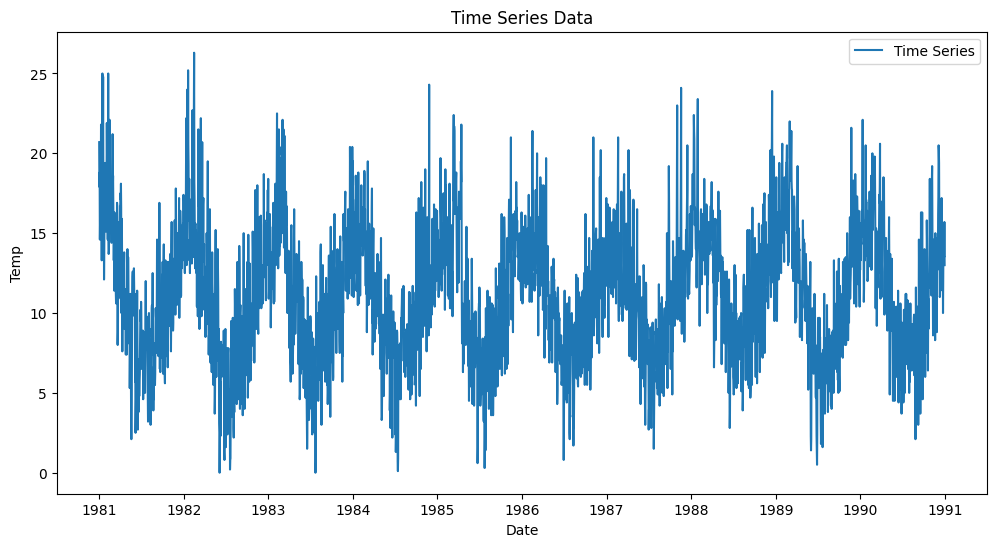

In [13]:
# Visual dataset
plt.figure(figsize=(12, 6))
plt.plot(df_temp.index, df_temp['Temp'], label='Time Series')
plt.xlabel('Date')
plt.ylabel('Temp')
plt.title('Time Series Data')
plt.legend()
plt.show()

<Figure size 1200x600 with 0 Axes>

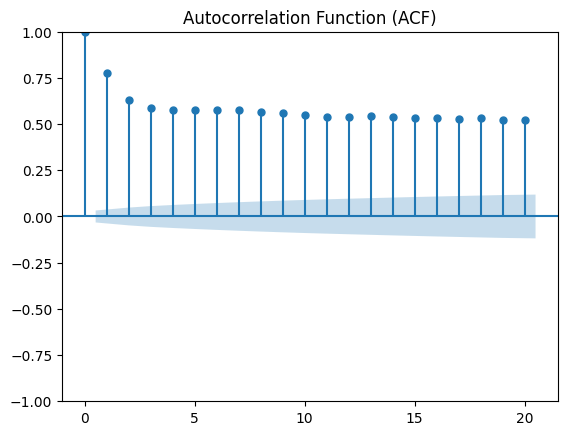

In [15]:
# ACF plots
plt.figure(figsize=(12, 6))
plot_acf(df_temp['Temp'], lags=20, title='Autocorrelation Function (ACF)')
plt.show()

<Figure size 1200x600 with 0 Axes>

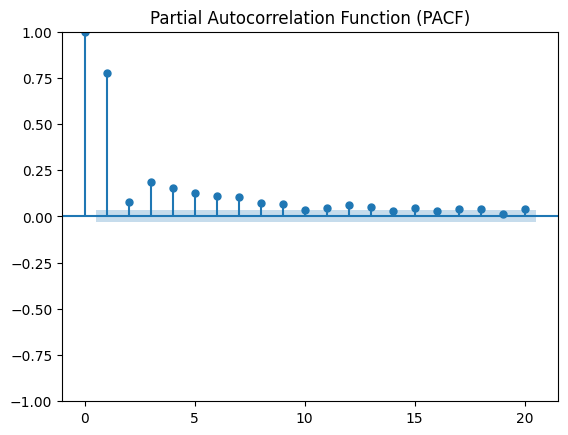

In [16]:
plt.figure(figsize=(12, 6))
plot_pacf(df_temp['Temp'], lags=20, title='Partial Autocorrelation Function (PACF)')
plt.show()

In [17]:
# Augmented Dickey-Fuller
adf_test = adfuller(df_temp['Temp'])
print(f'ADF Test Results:')
print(f'ADF Statistic: {adf_test[0]}')
print(f'p-value: {adf_test[1]}')
print(f'Critical Values: {adf_test[4]}')

ADF Test Results:
ADF Statistic: -4.444804924611699
p-value: 0.0002470826300360998
Critical Values: {'1%': -3.4321532327220154, '5%': -2.862336767636517, '10%': -2.56719413172842}


In [18]:
if adf_test[1] <= 0.05:
    print("The data is stationary.")
else:
    print("The data is non-stationary.")

The data is stationary.


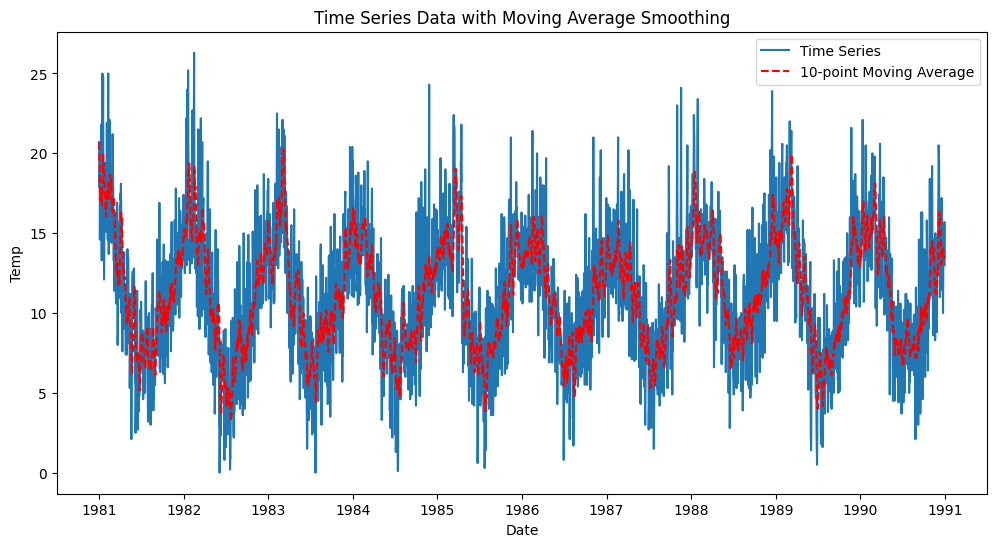

In [19]:
window_size = 10  # Adjust the window size as needed
df_temp['moving_average'] = df_temp['Temp'].rolling(window=window_size, min_periods=1).mean()

plt.figure(figsize=(12, 6))
plt.plot(df_temp.index, df_temp['Temp'], label='Time Series')
plt.plot(df_temp.index, df_temp['moving_average'], label=f'{window_size}-point Moving Average', color='red', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Temp')
plt.title('Time Series Data with Moving Average Smoothing')
plt.legend()
plt.show()

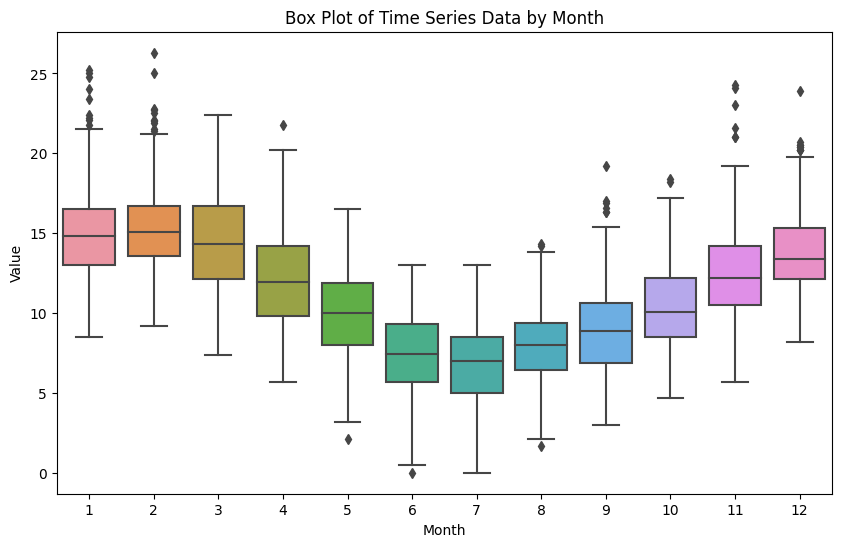

In [20]:
df_temp['month'] = df_temp.index.month

# Create a box plot to visualize the distribution for each month.
plt.figure(figsize=(10, 6))
sns.boxplot(x='month', y='Temp', data=df_temp)
plt.xlabel('Month')
plt.ylabel('Value')
plt.title('Box Plot of Time Series Data by Month')
plt.show()

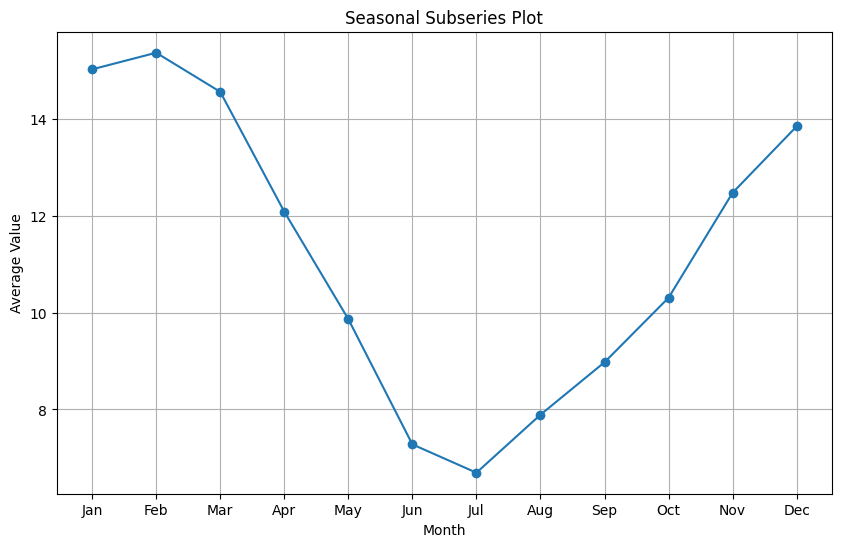

In [21]:
import calendar
# Seasonal Subseries Plot
seasonal_period = 12  # Assuming monthly data, adjust this value as per your data's seasonal period
df_temp['month'] = df_temp.index.month
seasonal_subseries = df_temp.groupby('month')['Temp'].mean()

plt.figure(figsize=(10, 6))
plt.plot(seasonal_subseries.index, seasonal_subseries.values, marker='o', linestyle='-')
plt.xlabel('Month')
plt.ylabel('Average Value')
plt.title('Seasonal Subseries Plot')
plt.xticks(range(1, 13), calendar.month_abbr[1:13])
plt.grid(True)
plt.show()

In [24]:
result = STL(df_temp['Temp'], period=seasonal_period).fit()
trend = result.trend
seasonal = result.seasonal
residual = result.resid

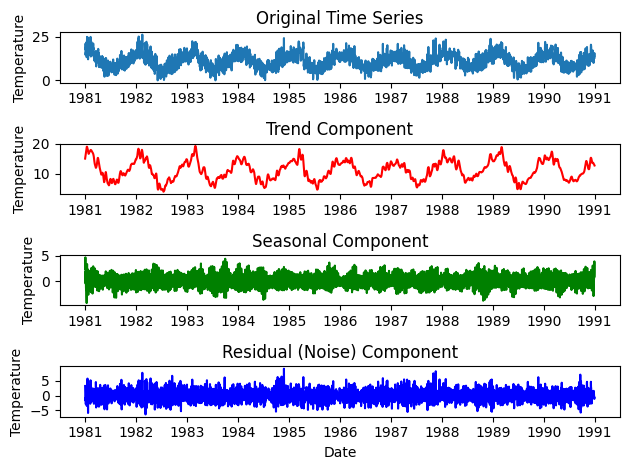

In [25]:
# Original time series
plt.subplot(4, 1, 1)
plt.plot(df_temp.index, df_temp['Temp'], label='Time Series')
plt.ylabel('Temperature')
plt.title('Original Time Series')

# Trend component
plt.subplot(4, 1, 2)
plt.plot(df_temp.index, trend, label='Trend Component', color='red')
plt.ylabel('Temperature')
plt.title('Trend Component')

# Seasonal component
plt.subplot(4, 1, 3)
plt.plot(df_temp.index, seasonal, label='Seasonal Component', color='green')
plt.ylabel('Temperature')
plt.title('Seasonal Component')

# Residual component
plt.subplot(4, 1, 4)
plt.plot(df_temp.index, residual, label='Residual (Noise)', color='blue')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.title('Residual (Noise) Component')

plt.tight_layout()
plt.show()

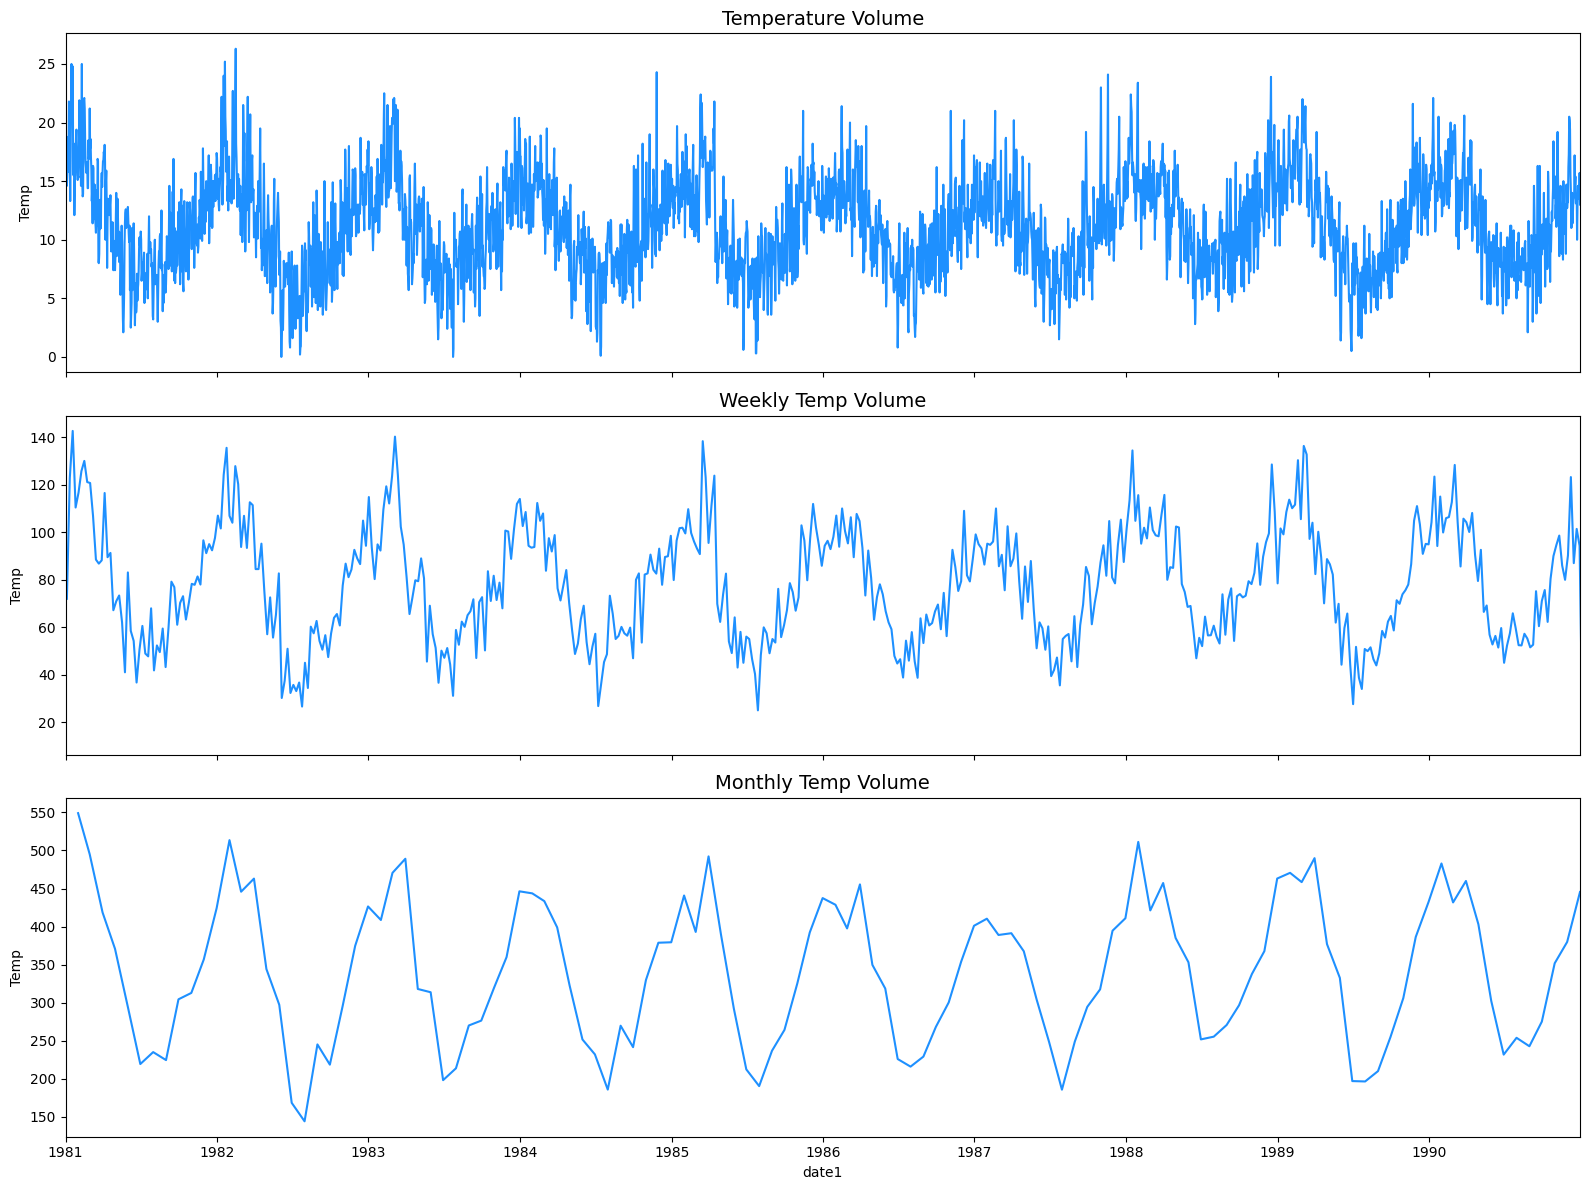

In [89]:
# Smoothing data / Resampling
df_temp['date1'] = pd.to_datetime(df_temp['Date'])
fig, ax = plt.subplots(ncols=1, nrows=3, sharex=True, figsize=(16, 12))

# Plot the original drainage volume time series
sns.lineplot(data=df_temp, x='date1', y='Temp', color='dodgerblue', ax=ax[0])
ax[0].set_title('Temperature Volume', fontsize=14)

# Resample the data to weekly intervals
resampled_weekly_df = df_temp.resample('W', on='date1').sum().reset_index()
sns.lineplot(data=resampled_weekly_df, x='date1', y='Temp', color='dodgerblue', ax=ax[1])
ax[1].set_title('Weekly Temp Volume', fontsize=14)

# Resample the data to monthly intervals
resampled_monthly_df = df_temp.resample('M', on='date1').sum().reset_index()
sns.lineplot(data=resampled_monthly_df, x='date1', y='Temp', color='dodgerblue', ax=ax[2])
ax[2].set_title('Monthly Temp Volume', fontsize=14)

# Set common x-axis limit for all plots
ax[0].set_xlim([pd.to_datetime('1981-01-01'), pd.to_datetime('1990-12-31')])

# Display the plots
plt.tight_layout()
plt.show() 

In [186]:
#split data
train_size = int(len(df_temp) * 0.8)
train_data, test_data = df_temp.iloc[:train_size], df_temp.iloc[train_size:]

In [189]:
"""
From mean & std We can interprete model acceptance. 
if test values mean far from the mae then model works good
"""
test_mean=test_data['Temp'].mean()
test_std = test_data['Temp'].std()
test_mean,  test_std

(11.465753424657533, 4.106611457397119)

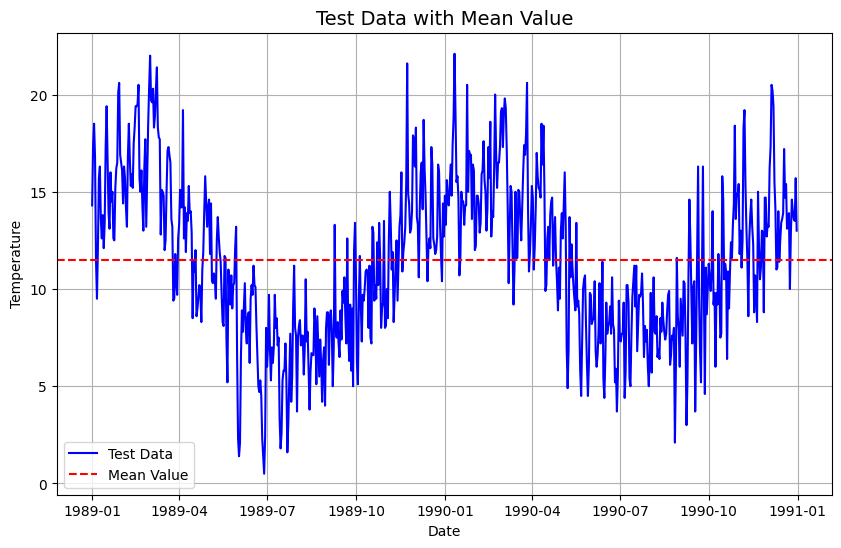

In [35]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(test_data.index, test_data['Temp'], label='Test Data', color='blue')
plt.axhline(y=test_mean, color='red', linestyle='--', label='Mean Value')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.title('Test Data with Mean Value', fontsize=14)
plt.legend()
plt.grid(True)
plt.show()

#### AR Model

[I 2023-08-03 14:40:01,461] A new study created in memory with name: no-name-023aaa43-fd5b-4795-9980-5d6505c6fa95
[I 2023-08-03 14:40:01,854] Trial 0 finished with value: 3.385844800357832 and parameters: {'p': 2}. Best is trial 0 with value: 3.385844800357832.
[I 2023-08-03 14:40:02,235] Trial 1 finished with value: 3.385844800357832 and parameters: {'p': 2}. Best is trial 0 with value: 3.385844800357832.
[I 2023-08-03 14:40:02,607] Trial 2 finished with value: 3.3987938650144307 and parameters: {'p': 0}. Best is trial 0 with value: 3.385844800357832.
[I 2023-08-03 14:40:03,000] Trial 3 finished with value: 3.385844800357832 and parameters: {'p': 2}. Best is trial 0 with value: 3.385844800357832.
[I 2023-08-03 14:40:03,384] Trial 4 finished with value: 3.3987938650144307 and parameters: {'p': 0}. Best is trial 0 with value: 3.385844800357832.
[I 2023-08-03 14:40:03,755] Trial 5 finished with value: 3.3987938650144307 and parameters: {'p': 0}. Best is trial 0 with value: 3.385844800357

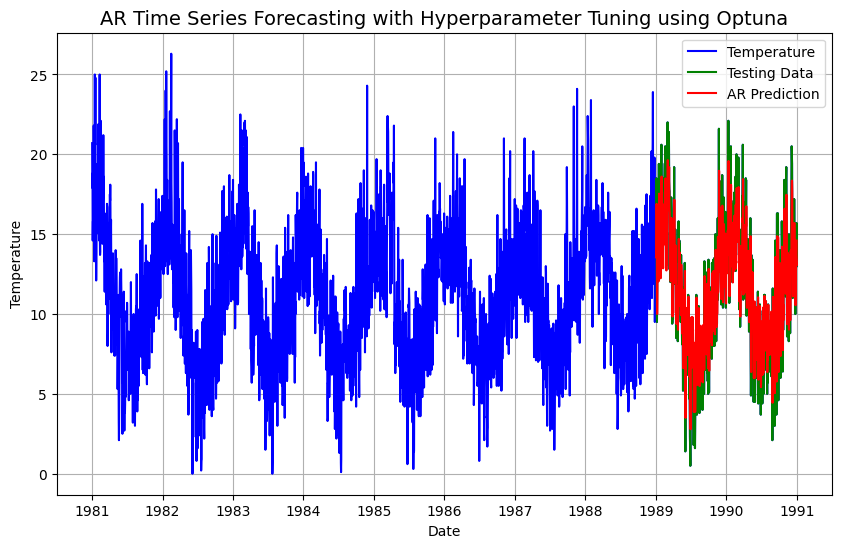

Best Hyperparameters: {'p': 2}
Best MAE: 3.385844800357832


In [190]:
def objective(trial):
    p = trial.suggest_int('p', 0, 2)

    #suggested hyperparameters
    model = ARIMA(train_data['Temp'], order=(p, 0, 0))  # Train on the train_data
    model_fit = model.fit()
    
    start = len(train_data)
    end = len(df_temp) - 1
    y_pred = model_fit.predict(start=start, end=end)

    # Mae calculate
    mae = mean_absolute_error(test_data['Temp'], y_pred)
    return mae

# hyperparameter search
study = optuna.create_study(direction='minimize')  # Minimize the MAE
study.optimize(objective, n_trials=10)  # Perform 10 trials (can be adjusted)

# best hyperparameters 
best_params = study.best_trial.params
best_p = best_params['p']  # Access the best hyperparameter value for 'p'
best_model = ARIMA(df_temp['Temp'], order=(best_p, 0, 0))  # Train on the entire dataset
best_model_fit = best_model.fit()
##make prediction
start = len(train_data)
end = len(df_temp) - 1
y_pred = best_model_fit.predict(start=start, end=end, type="levels")

plt.figure(figsize=(10, 6))
plt.plot(df_temp.index, df_temp['Temp'], label='Temperature', color='blue')
plt.plot(test_data.index, test_data['Temp'], label='Testing Data', color='green')
plt.plot(test_data.index, y_pred, label='AR Prediction', color='red')  # Adjust the index for predictions
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.title('AR Time Series Forecasting with Hyperparameter Tuning using Optuna', fontsize=14)
plt.legend()
plt.grid(True)
plt.show()

# Step 8: Print the best hyperparameters and their MAE score
print('Best Hyperparameters:', best_params)
print('Best MAE:', study.best_value)
ar1=study.best_value

#### MA Model

[I 2023-08-03 14:40:26,011] A new study created in memory with name: no-name-c2ca8456-6b1a-440c-b973-d906c61040fa
[I 2023-08-03 14:40:26,705] Trial 0 finished with value: 2.082741440186714 and parameters: {'q': 3}. Best is trial 0 with value: 2.082741440186714.
[I 2023-08-03 14:40:27,859] Trial 1 finished with value: 2.027392621347705 and parameters: {'q': 4}. Best is trial 1 with value: 2.027392621347705.
[I 2023-08-03 14:40:28,294] Trial 2 finished with value: 2.1768035346734576 and parameters: {'q': 2}. Best is trial 1 with value: 2.027392621347705.
[I 2023-08-03 14:40:28,752] Trial 3 finished with value: 2.1768035346734576 and parameters: {'q': 2}. Best is trial 1 with value: 2.027392621347705.
[I 2023-08-03 14:40:29,063] Trial 4 finished with value: 3.3974130413315446 and parameters: {'q': 0}. Best is trial 1 with value: 2.027392621347705.
[I 2023-08-03 14:40:29,745] Trial 5 finished with value: 2.082741440186714 and parameters: {'q': 3}. Best is trial 1 with value: 2.027392621347

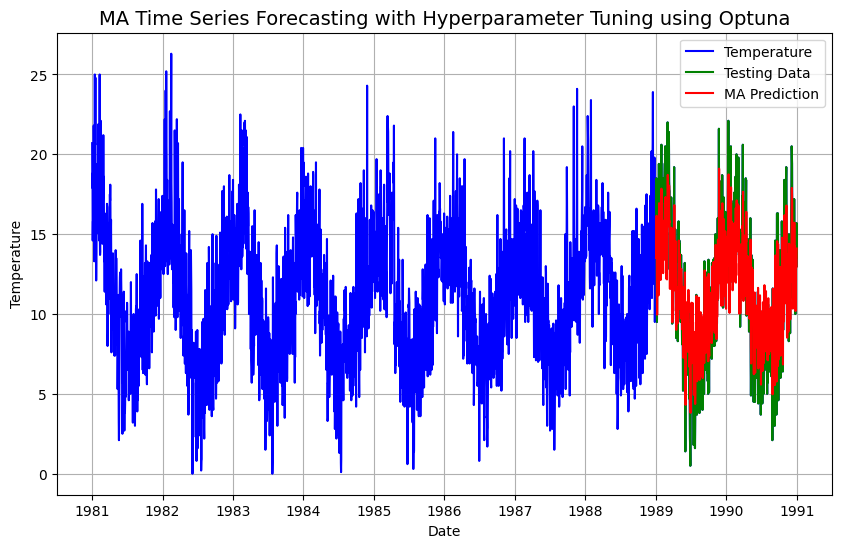

Best Hyperparameters: {'q': 5}
Best MAE: 1.990633012912239


In [191]:
def objective(trial):
    q = trial.suggest_int('q', 0, 5)

    # Train suggested hyperparameters
    model = ARIMA(df_temp['Temp'], order=(0, 0, q))
    model_fit = model.fit()

    start = len(train_data)
    end = len(train_data) + len(test_data) - 1
    y_pred = model_fit.predict(start=start, end=end, type="levels")

    # MAE calculate
    mae = mean_absolute_error(test_data['Temp'], y_pred)
    return mae

#  hyperparameter search
study = optuna.create_study(direction='minimize')  # Minimize the MAE
study.optimize(objective, n_trials=10)  # Perform 100 trials (can be adjusted)

# best hyperparameters
best_params = study.best_params
best_q = best_params['q']
best_model = ARIMA(df_temp['Temp'], order=(0, 0, best_q))
best_model_fit = best_model.fit()

# Make predictions
start = len(train_data)
end = len(train_data) + len(test_data) - 1
y_pred = best_model_fit.predict(start=start, end=end, type="levels")

# predictions plot
y_pred.index = df_temp.index[start:end+1]

plt.figure(figsize=(10, 6))
plt.plot(df_temp.index, df_temp['Temp'], label='Temperature', color='blue')
plt.plot(test_data.index, test_data['Temp'], label='Testing Data', color='green')
plt.plot(test_data.index, y_pred, label='MA Prediction', color='red')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.title('MA Time Series Forecasting with Hyperparameter Tuning using Optuna', fontsize=14)
plt.legend()
plt.grid(True)
plt.show()

# Step 6: Print the best hyperparameters and their MAE score
print('Best Hyperparameters:', best_params)
print('Best MAE:', study.best_value)
ma1=study.best_value

#### ARMA Model

[I 2023-08-03 14:40:50,728] A new study created in memory with name: no-name-7aceca79-2103-4aea-a4cc-073cb7fdbed7
[I 2023-08-03 14:40:53,079] Trial 0 finished with value: 1.7323444986895593 and parameters: {'p': 4, 'q': 1}. Best is trial 0 with value: 1.7323444986895593.
[I 2023-08-03 14:40:55,492] Trial 1 finished with value: 1.7320786084303195 and parameters: {'p': 1, 'q': 4}. Best is trial 1 with value: 1.7320786084303195.
[I 2023-08-03 14:40:55,964] Trial 2 finished with value: 1.8822251241746848 and parameters: {'p': 2, 'q': 0}. Best is trial 1 with value: 1.7320786084303195.
[I 2023-08-03 14:40:56,204] Trial 3 finished with value: 1.8902779661117088 and parameters: {'p': 1, 'q': 0}. Best is trial 1 with value: 1.7320786084303195.
[I 2023-08-03 14:40:59,513] Trial 4 finished with value: 1.73259746732385 and parameters: {'p': 4, 'q': 3}. Best is trial 1 with value: 1.7320786084303195.
[I 2023-08-03 14:41:01,675] Trial 5 finished with value: 1.7461755877470193 and parameters: {'p': 

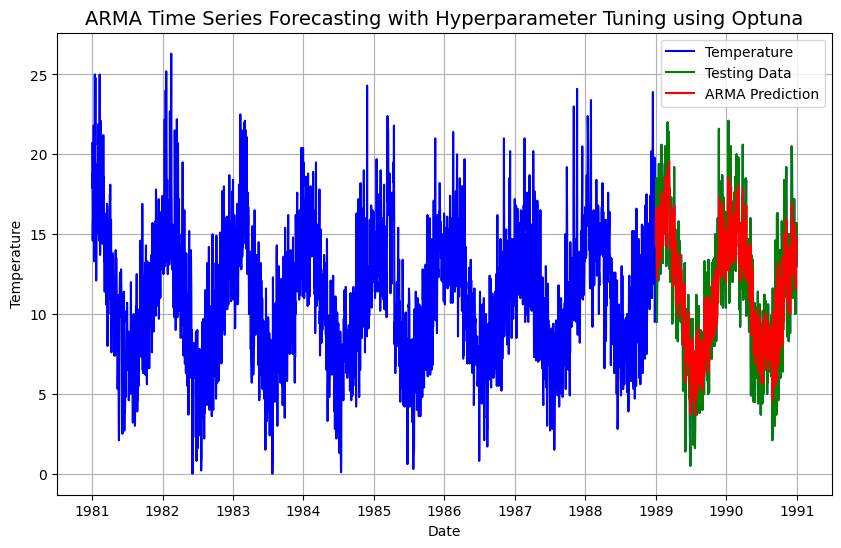

Best Hyperparameters: {'p': 1, 'q': 4}
Best MAE: 1.7320786084303195


In [192]:
def objective(trial):
    p = trial.suggest_int('p', 0, 5)
    q = trial.suggest_int('q', 0, 5)

    # Train on suggested hyperparameters
    model = ARIMA(df_temp['Temp'], order=(p, 0, q))
    model_fit = model.fit()

    start = len(train_data)
    end = len(train_data) + len(test_data) - 1
    y_pred = model_fit.predict(start=start, end=end, type="levels")

    # MAE calculation
    mae = mean_absolute_error(test_data['Temp'], y_pred)
    return mae

#hyperparameter search
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)  

#best hyperparametersset
best_params = study.best_params
best_p, best_q = best_params['p'], best_params['q']
best_model = ARIMA(df_temp['Temp'], order=(best_p, 0, best_q))
best_model_fit = best_model.fit()

# Make predictions 
start = len(train_data)
end = len(train_data) + len(test_data) - 1
y_pred = best_model_fit.predict(start=start, end=end, type="levels")

#  Plot  predictions 
y_pred.index = df_temp.index[start:end+1]

plt.figure(figsize=(10, 6))
plt.plot(df_temp.index, df_temp['Temp'], label='Temperature', color='blue')
plt.plot(test_data.index, test_data['Temp'], label='Testing Data', color='green')
plt.plot(test_data.index, y_pred, label='ARMA Prediction', color='red')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.title('ARMA Time Series Forecasting with Hyperparameter Tuning using Optuna', fontsize=14)
plt.legend()
plt.grid(True)
plt.show()

#Print the best hyperparameters and their MAE score
print('Best Hyperparameters:', best_params)
print('Best MAE:', study.best_value)
arma1=study.best_value

#### ARIMA Model

[I 2023-08-03 14:41:27,669] A new study created in memory with name: no-name-0f3c161e-4f0e-4415-aab6-104490bea99e
[I 2023-08-03 14:41:28,228] Trial 0 finished with value: 1.8663110184615923 and parameters: {'p': 1, 'd': 0, 'q': 1}. Best is trial 0 with value: 1.8663110184615923.
[I 2023-08-03 14:41:28,517] Trial 1 finished with value: 3.3974130413315446 and parameters: {'p': 0, 'd': 0, 'q': 0}. Best is trial 0 with value: 1.8663110184615923.
[I 2023-08-03 14:41:28,616] Trial 2 finished with value: 1.874424234362216 and parameters: {'p': 2, 'd': 1, 'q': 0}. Best is trial 0 with value: 1.8663110184615923.
[I 2023-08-03 14:41:28,912] Trial 3 finished with value: 1.738489290595077 and parameters: {'p': 1, 'd': 1, 'q': 2}. Best is trial 3 with value: 1.738489290595077.
[I 2023-08-03 14:41:31,084] Trial 4 finished with value: 1.7461755877470193 and parameters: {'p': 2, 'd': 0, 'q': 1}. Best is trial 3 with value: 1.738489290595077.
[I 2023-08-03 14:41:31,416] Trial 5 finished with value: 1.7

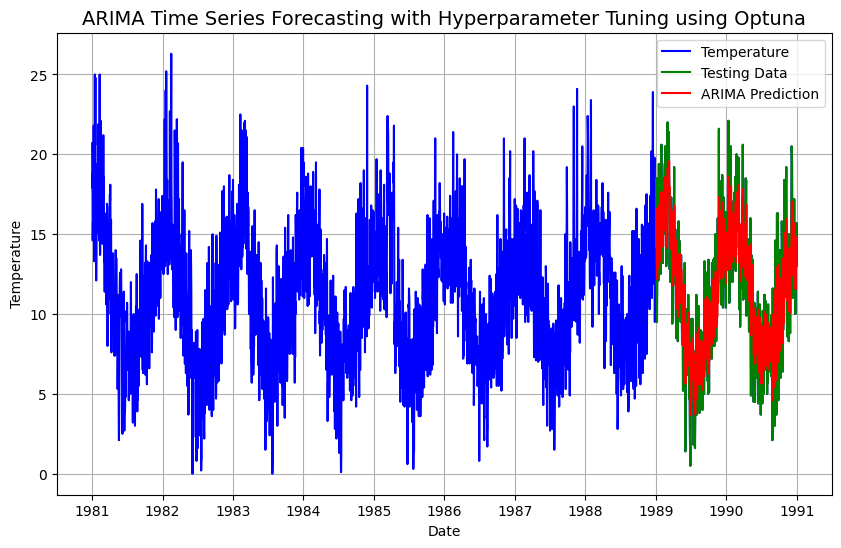

Best Hyperparameters: {'p': 2, 'd': 0, 'q': 2}
Best MAE: 1.7330437348681005


In [193]:
def objective(trial):
    p = trial.suggest_int('p', 0, 2)
    d = trial.suggest_int('d', 0, 1)
    q = trial.suggest_int('q', 0, 2)

    # Train suggested hyperparameters
    model = ARIMA(df_temp['Temp'], order=(p, d, q))
    model_fit = model.fit()

    # Make predictions on training data
    start = len(train_data)
    end = len(train_data) + len(test_data) - 1
    y_pred = model_fit.predict(start=start, end=end, type="levels")

    # MAE error calculation
    mae = mean_absolute_error(test_data['Temp'], y_pred)
    return mae

# hyperparameter search
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)  

# best hyperparameters
best_params = study.best_params
best_p, best_d, best_q = best_params['p'], best_params['d'], best_params['q']
best_model = ARIMA(df_temp['Temp'], order=(best_p, best_d, best_q))
best_model_fit = best_model.fit()

#prediction
start = len(train_data)
end = len(train_data) + len(test_data) - 1
y_pred = best_model_fit.predict(start=start, end=end, type="levels")

# Plot the predictions and the actual test data
y_pred.index = df_temp.index[start:end+1]

plt.figure(figsize=(10, 6))
plt.plot(df_temp.index, df_temp['Temp'], label='Temperature', color='blue')
plt.plot(test_data.index, test_data['Temp'], label='Testing Data', color='green')
plt.plot(test_data.index, y_pred, label='ARIMA Prediction', color='red')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.title('ARIMA Time Series Forecasting with Hyperparameter Tuning using Optuna', fontsize=14)
plt.legend()
plt.grid(True)
plt.show()
# Print the best hyperparameters and their MAE score
print('Best Hyperparameters:', best_params)
print('Best MAE:', study.best_value)
arima1=study.best_value

#### Lets work on Sunspots data

In [194]:
df_sun = pd.read_csv('C:/Users/gazur/Desktop/Polyfins_Intern-2023/dataset/Time Series/monthly-sunspots.csv',index_col="Month", parse_dates=['Month'])

In [195]:
df_sun

,Sunspots
Month,
1749-01-01,58.0
1749-02-01,62.6
1749-03-01,70.0
1749-04-01,55.7
1749-05-01,85.0
...,...
1983-08-01,71.8
1983-09-01,50.3
1983-10-01,55.8


In [196]:
df_sun.shape, df_sun.isna().sum()

((2820, 1),
 Sunspots    0
 dtype: int64)

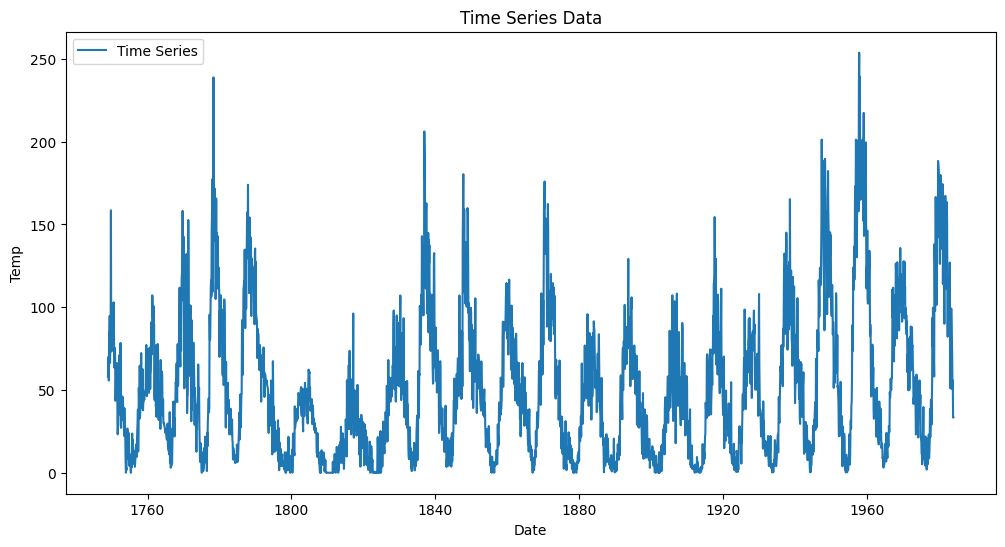

In [136]:
# Visual dataset
plt.figure(figsize=(12, 6))
plt.plot(df_sun.index, df_sun['Sunspots'], label='Time Series')
plt.xlabel('Date')
plt.ylabel('Temp')
plt.title('Time Series Data')
plt.legend()
plt.show()

<Figure size 1200x600 with 0 Axes>

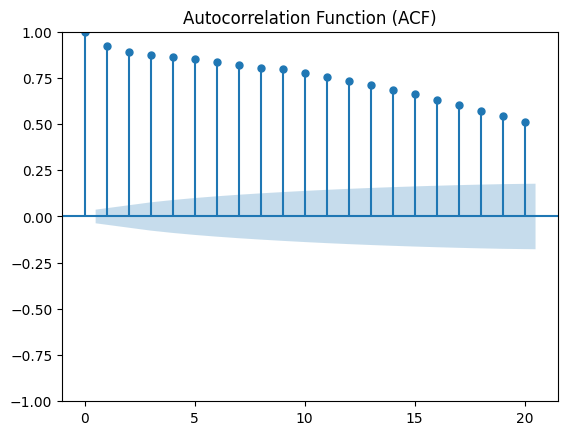

In [137]:
# ACF and PACF plots
plt.figure(figsize=(12, 6))
plot_acf(df_sun['Sunspots'], lags=20, title='Autocorrelation Function (ACF)')
plt.show()

<Figure size 1200x600 with 0 Axes>

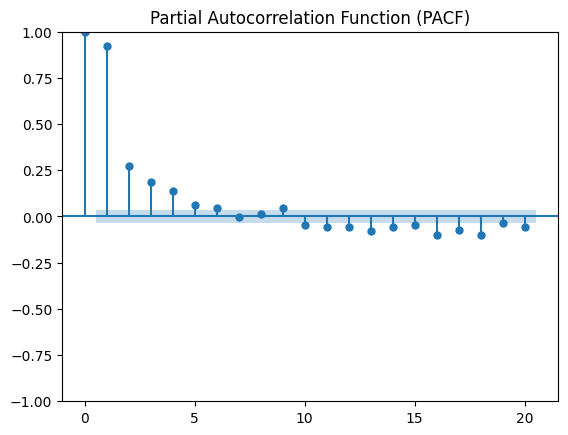

In [104]:
plt.figure(figsize=(12, 6))
plot_pacf(df_sun['Sunspots'], lags=20, title='Partial Autocorrelation Function (PACF)')
plt.show()

In [105]:
# Augmented Dickey-Fuller
adf_test = adfuller(df_sun['Sunspots'])
print(f'ADF Test Results:')
print(f'ADF Statistic: {adf_test[0]}')
print(f'p-value: {adf_test[1]}')
print(f'Critical Values: {adf_test[4]}')

ADF Test Results:
ADF Statistic: -9.56766751191308
p-value: 2.3334521438662885e-16
Critical Values: {'1%': -3.432694313168895, '5%': -2.862575752726396, '10%': -2.5673213632123297}


In [106]:
if adf_test[1] <= 0.05:
    print("The data is stationary.")
else:
    print("The data is non-stationary.")

The data is stationary.


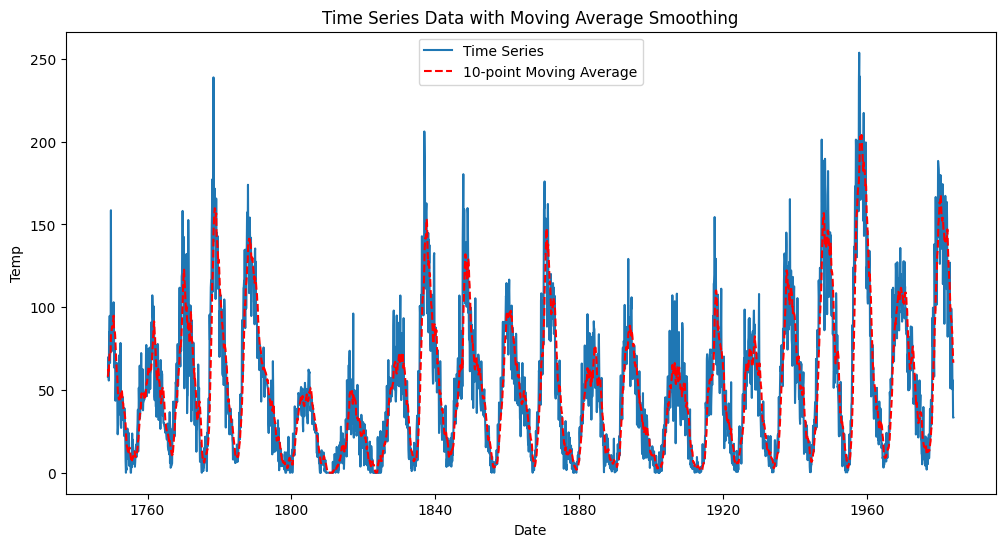

In [138]:
window_size = 10  # Adjust the window size as needed
df_sun['moving_average'] = df_sun['Sunspots'].rolling(window=window_size, min_periods=1).mean()

plt.figure(figsize=(12, 6))
plt.plot(df_sun.index, df_sun['Sunspots'], label='Time Series')
plt.plot(df_sun.index, df_sun['moving_average'], label=f'{window_size}-point Moving Average', color='red', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Temp')
plt.title('Time Series Data with Moving Average Smoothing')
plt.legend()
plt.show()

In [197]:
#split data
train_size = int(len(df_sun) * 0.8)
train_data, test_data = df_sun.iloc[:train_size], df_sun.iloc[train_size:]

In [198]:
test_mean=test_data['Sunspots'].mean()
test_std = test_data['Sunspots'].std()
test_mean,  test_std

(77.67145390070921, 55.048310938087965)

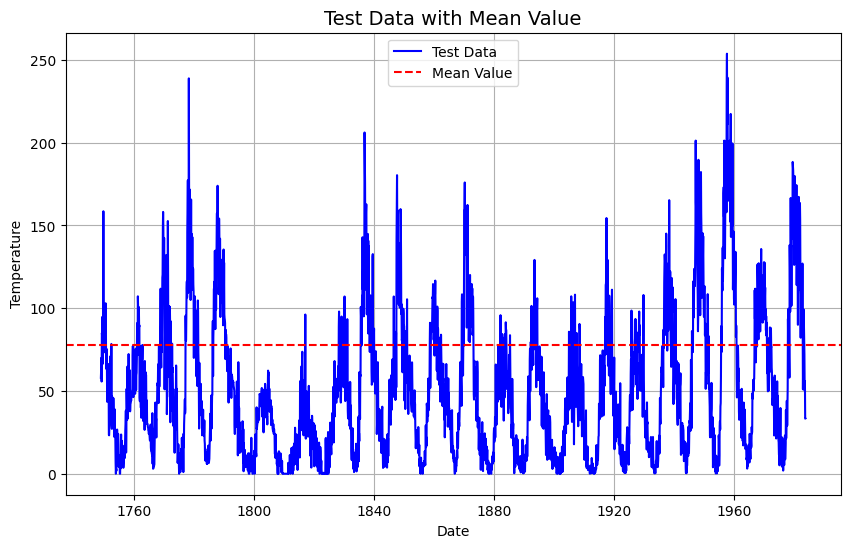

In [199]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(df_sun.index, df_sun['Sunspots'], label='Test Data', color='blue')
plt.axhline(y=test_mean, color='red', linestyle='--', label='Mean Value')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.title('Test Data with Mean Value', fontsize=14)
plt.legend()
plt.grid(True)
plt.show()

#### AR

[I 2023-08-03 14:42:31,764] A new study created in memory with name: no-name-24fb4c91-2321-4647-adc3-2a484f2e5a72
[I 2023-08-03 14:42:32,193] Trial 0 finished with value: 49.777728844338974 and parameters: {'p': 0}. Best is trial 0 with value: 49.777728844338974.
[I 2023-08-03 14:42:32,626] Trial 1 finished with value: 49.777728844338974 and parameters: {'p': 0}. Best is trial 0 with value: 49.777728844338974.
[I 2023-08-03 14:42:32,999] Trial 2 finished with value: 48.450406319358834 and parameters: {'p': 1}. Best is trial 2 with value: 48.450406319358834.
[I 2023-08-03 14:42:33,358] Trial 3 finished with value: 48.450406319358834 and parameters: {'p': 1}. Best is trial 2 with value: 48.450406319358834.
[I 2023-08-03 14:42:33,795] Trial 4 finished with value: 49.777728844338974 and parameters: {'p': 0}. Best is trial 2 with value: 48.450406319358834.
[I 2023-08-03 14:42:34,152] Trial 5 finished with value: 48.450406319358834 and parameters: {'p': 1}. Best is trial 2 with value: 48.450

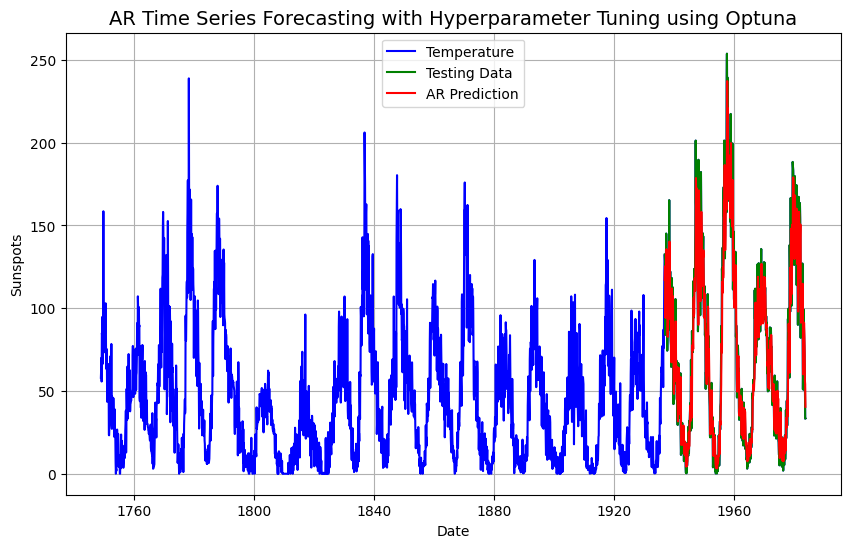

Best Hyperparameters: {'p': 2}
Best MAE: 47.80613339330426


In [200]:
def objective(trial):
    p = trial.suggest_int('p', 0, 2)

    #suggested hyperparameters
    model = ARIMA(train_data['Sunspots'], order=(p, 0, 0))  # Train on the train_data
    model_fit = model.fit()
    
    start = len(train_data)
    end = len(df_sun) - 1
    y_pred = model_fit.predict(start=start, end=end)

    # Mae calculate
    mae = mean_absolute_error(test_data['Sunspots'], y_pred)
    return mae

# hyperparameter search
study = optuna.create_study(direction='minimize')  # Minimize the MAE
study.optimize(objective, n_trials=10)  # Perform 10 trials (can be adjusted)

# best hyperparameters 
best_params = study.best_trial.params
best_p = best_params['p']  # Access the best hyperparameter value for 'p'
best_model = ARIMA(df_sun['Sunspots'], order=(best_p, 0, 0))  # Train on the entire dataset
best_model_fit = best_model.fit()
##make prediction
start = len(train_data)
end = len(df_sun) - 1
y_pred = best_model_fit.predict(start=start, end=end, type="levels")

plt.figure(figsize=(10, 6))
plt.plot(df_sun.index, df_sun['Sunspots'], label='Temperature', color='blue')
plt.plot(test_data.index, test_data['Sunspots'], label='Testing Data', color='green')
plt.plot(test_data.index, y_pred, label='AR Prediction', color='red')  # Adjust the index for predictions
plt.xlabel('Date')
plt.ylabel('Sunspots')
plt.title('AR Time Series Forecasting with Hyperparameter Tuning using Optuna', fontsize=14)
plt.legend()
plt.grid(True)
plt.show()

# Step 8: Print the best hyperparameters and their MAE score
print('Best Hyperparameters:', best_params)
print('Best MAE:', study.best_value)
ar2=study.best_value

#### MA 

[I 2023-08-03 14:42:53,835] A new study created in memory with name: no-name-2593c312-2ce2-4f3d-975d-bd5e77787de7
[I 2023-08-03 14:42:54,260] Trial 0 finished with value: 29.400029002605486 and parameters: {'q': 1}. Best is trial 0 with value: 29.400029002605486.
[I 2023-08-03 14:42:55,434] Trial 1 finished with value: 18.565247676025113 and parameters: {'q': 4}. Best is trial 1 with value: 18.565247676025113.
[I 2023-08-03 14:42:55,824] Trial 2 finished with value: 48.165215202925204 and parameters: {'q': 0}. Best is trial 1 with value: 18.565247676025113.
[I 2023-08-03 14:42:56,411] Trial 3 finished with value: 22.656242376659357 and parameters: {'q': 2}. Best is trial 1 with value: 18.565247676025113.
[I 2023-08-03 14:42:57,686] Trial 4 finished with value: 17.39889006533624 and parameters: {'q': 5}. Best is trial 4 with value: 17.39889006533624.
[I 2023-08-03 14:42:58,306] Trial 5 finished with value: 22.656242376659357 and parameters: {'q': 2}. Best is trial 4 with value: 17.39889

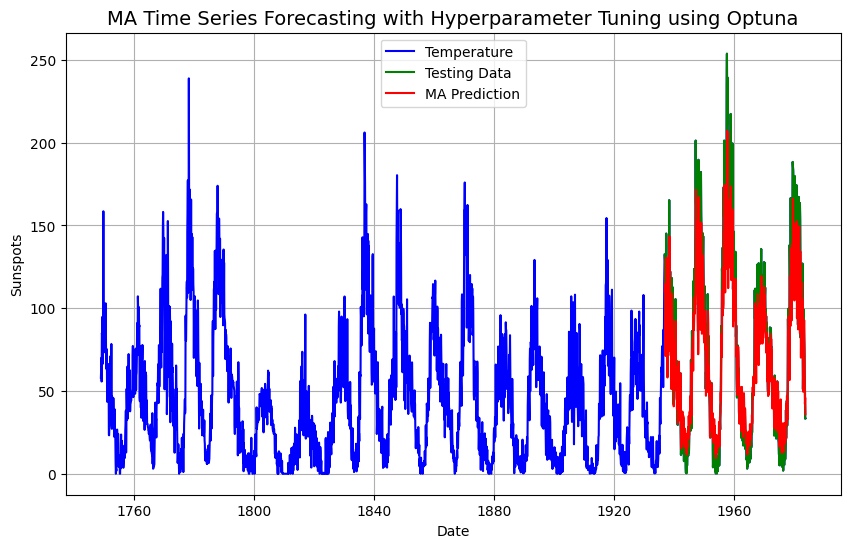

Best Hyperparameters: {'q': 5}
Best MAE: 17.39889006533624


In [201]:
def objective(trial):
    q = trial.suggest_int('q', 0, 5)

    # Train suggested hyperparameters
    model = ARIMA(df_sun['Sunspots'], order=(0, 0, q))
    model_fit = model.fit()

    start = len(train_data)
    end = len(train_data) + len(test_data) - 1
    y_pred = model_fit.predict(start=start, end=end, type="levels")

    # MAE calculate
    mae = mean_absolute_error(test_data['Sunspots'], y_pred)
    return mae

#  hyperparameter search
study = optuna.create_study(direction='minimize')  # Minimize the MAE
study.optimize(objective, n_trials=10)  # Perform 100 trials (can be adjusted)

# best hyperparameters
best_params = study.best_params
best_q = best_params['q']
best_model = ARIMA(df_sun['Sunspots'], order=(0, 0, best_q))
best_model_fit = best_model.fit()

# Make predictions
start = len(train_data)
end = len(train_data) + len(test_data) - 1
y_pred = best_model_fit.predict(start=start, end=end, type="levels")

# predictions plot
y_pred.index = df_temp.index[start:end+1]

plt.figure(figsize=(10, 6))
plt.plot(df_sun.index, df_sun['Sunspots'], label='Temperature', color='blue')
plt.plot(test_data.index, test_data['Sunspots'], label='Testing Data', color='green')
plt.plot(test_data.index, y_pred, label='MA Prediction', color='red')
plt.xlabel('Date')
plt.ylabel('Sunspots')
plt.title('MA Time Series Forecasting with Hyperparameter Tuning using Optuna', fontsize=14)
plt.legend()
plt.grid(True)
plt.show()

# Step 6: Print the best hyperparameters and their MAE score
print('Best Hyperparameters:', best_params)
print('Best MAE:', study.best_value)
ma2=study.best_value

#### ARMA

[I 2023-08-03 14:43:13,964] A new study created in memory with name: no-name-f4eaa9c9-4b68-48e3-a903-fd2fcc5338bb
[I 2023-08-03 14:43:19,823] Trial 0 finished with value: 13.692867861070148 and parameters: {'p': 5, 'q': 5}. Best is trial 0 with value: 13.692867861070148.
[I 2023-08-03 14:43:20,077] Trial 1 finished with value: 14.468835642648672 and parameters: {'p': 1, 'q': 0}. Best is trial 0 with value: 13.692867861070148.
[I 2023-08-03 14:43:20,989] Trial 2 finished with value: 13.828737853387215 and parameters: {'p': 2, 'q': 2}. Best is trial 0 with value: 13.692867861070148.
[I 2023-08-03 14:43:23,140] Trial 3 finished with value: 13.823529032668093 and parameters: {'p': 5, 'q': 1}. Best is trial 0 with value: 13.692867861070148.
[I 2023-08-03 14:43:24,601] Trial 4 finished with value: 13.821605427386704 and parameters: {'p': 4, 'q': 1}. Best is trial 0 with value: 13.692867861070148.
[I 2023-08-03 14:43:26,290] Trial 5 finished with value: 13.82441790245818 and parameters: {'p':

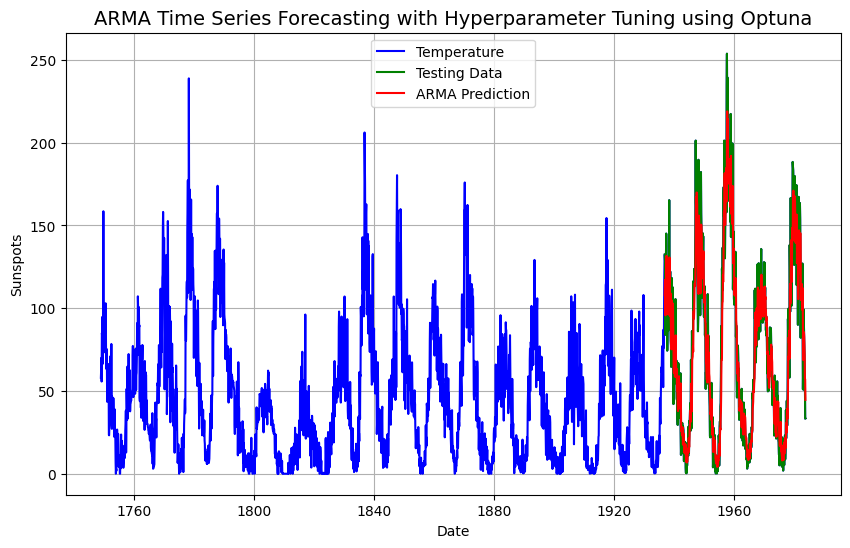

Best Hyperparameters: {'p': 5, 'q': 5}
Best MAE: 13.692867861070148


In [202]:
def objective(trial):
    p = trial.suggest_int('p', 0, 5)
    q = trial.suggest_int('q', 0, 5)

    # Train on suggested hyperparameters
    model = ARIMA(df_sun['Sunspots'], order=(p, 0, q))
    model_fit = model.fit()

    start = len(train_data)
    end = len(train_data) + len(test_data) - 1
    y_pred = model_fit.predict(start=start, end=end, type="levels")

    # MAE calculation
    mae = mean_absolute_error(test_data['Sunspots'], y_pred)
    return mae

#hyperparameter search
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)  

#best hyperparametersset
best_params = study.best_params
best_p, best_q = best_params['p'], best_params['q']
best_model = ARIMA(df_sun['Sunspots'], order=(best_p, 0, best_q))
best_model_fit = best_model.fit()

# Make predictions 
start = len(train_data)
end = len(train_data) + len(test_data) - 1
y_pred = best_model_fit.predict(start=start, end=end, type="levels")

#  Plot  predictions 
y_pred.index = df_temp.index[start:end+1]

plt.figure(figsize=(10, 6))
plt.plot(df_sun.index, df_sun['Sunspots'], label='Temperature', color='blue')
plt.plot(test_data.index, test_data['Sunspots'], label='Testing Data', color='green')
plt.plot(test_data.index, y_pred, label='ARMA Prediction', color='red')
plt.xlabel('Date')
plt.ylabel('Sunspots')
plt.title('ARMA Time Series Forecasting with Hyperparameter Tuning using Optuna', fontsize=14)
plt.legend()
plt.grid(True)
plt.show()

#Print the best hyperparameters and their MAE score
print('Best Hyperparameters:', best_params)
print('Best MAE:', study.best_value)
arma2=study.best_value

[I 2023-08-03 14:43:44,155] A new study created in memory with name: no-name-7e1c044e-a10c-4a09-a962-18c6a73c3853
[I 2023-08-03 14:43:44,600] Trial 0 finished with value: 13.91531097405859 and parameters: {'p': 2, 'd': 1, 'q': 1}. Best is trial 0 with value: 13.91531097405859.
[I 2023-08-03 14:43:45,557] Trial 1 finished with value: 13.828737853387215 and parameters: {'p': 2, 'd': 0, 'q': 2}. Best is trial 1 with value: 13.828737853387215.
[I 2023-08-03 14:43:46,556] Trial 2 finished with value: 13.854164911591665 and parameters: {'p': 2, 'd': 0, 'q': 1}. Best is trial 1 with value: 13.828737853387215.
[I 2023-08-03 14:43:47,554] Trial 3 finished with value: 13.854164911591665 and parameters: {'p': 2, 'd': 0, 'q': 1}. Best is trial 1 with value: 13.828737853387215.
[I 2023-08-03 14:43:48,538] Trial 4 finished with value: 13.828737853387215 and parameters: {'p': 2, 'd': 0, 'q': 2}. Best is trial 1 with value: 13.828737853387215.
[I 2023-08-03 14:43:48,926] Trial 5 finished with value: 1

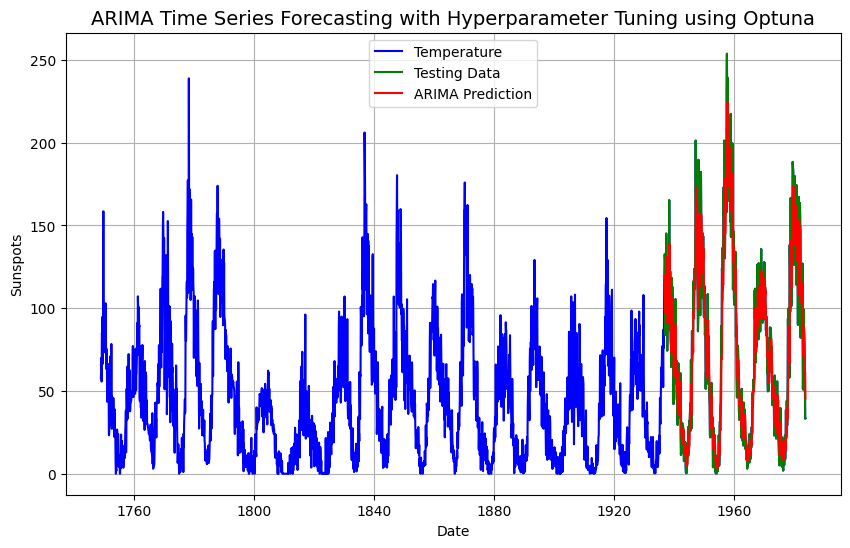

Best Hyperparameters: {'p': 2, 'd': 0, 'q': 2}
Best MAE: 13.828737853387215


In [203]:
def objective(trial):
    p = trial.suggest_int('p', 0, 2)
    d = trial.suggest_int('d', 0, 1)
    q = trial.suggest_int('q', 0, 2)

    # Train suggested hyperparameters
    model = ARIMA(df_sun['Sunspots'], order=(p, d, q))
    model_fit = model.fit()

    # Make predictions on training data
    start = len(train_data)
    end = len(train_data) + len(test_data) - 1
    y_pred = model_fit.predict(start=start, end=end, type="levels")

    # MAE error calculation
    mae = mean_absolute_error(test_data['Sunspots'], y_pred)
    return mae

# hyperparameter search
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)  

# best hyperparameters
best_params = study.best_params
best_p, best_d, best_q = best_params['p'], best_params['d'], best_params['q']
best_model = ARIMA(df_sun['Sunspots'], order=(best_p, best_d, best_q))
best_model_fit = best_model.fit()

#prediction
start = len(train_data)
end = len(train_data) + len(test_data) - 1
y_pred = best_model_fit.predict(start=start, end=end, type="levels")

# Plot the predictions and the actual test data
y_pred.index = df_temp.index[start:end+1]

plt.figure(figsize=(10, 6))
plt.plot(df_sun.index, df_sun['Sunspots'], label='Temperature', color='blue')
plt.plot(test_data.index, test_data['Sunspots'], label='Testing Data', color='green')
plt.plot(test_data.index, y_pred, label='ARIMA Prediction', color='red')
plt.xlabel('Date')
plt.ylabel('Sunspots')
plt.title('ARIMA Time Series Forecasting with Hyperparameter Tuning using Optuna', fontsize=14)
plt.legend()
plt.grid(True)
plt.show()
# Print the best hyperparameters and their MAE score
print('Best Hyperparameters:', best_params)
print('Best MAE:', study.best_value)
arima2=study.best_value

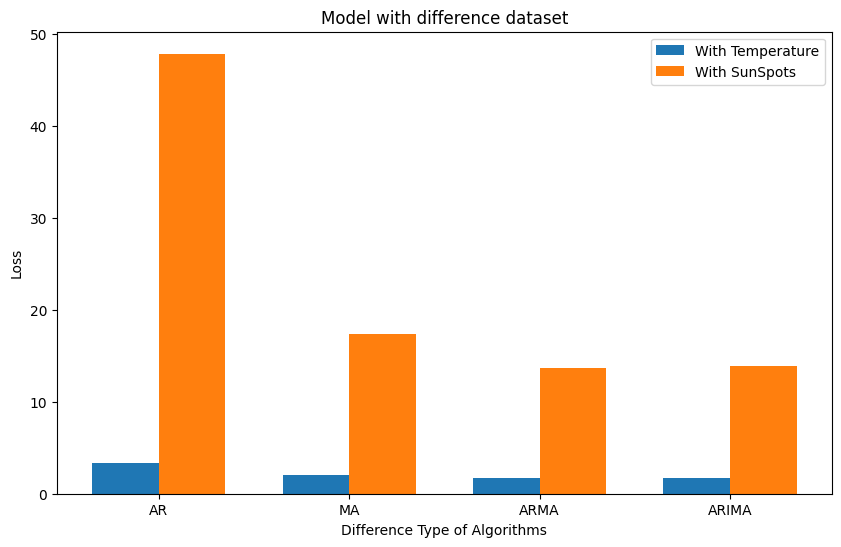

In [209]:
# Algorithms to compare
algorithms = ['AR', 'MA', 'ARMA', 'ARIMA']


mae1 = [ar1, ma1, arma1, arima1]

# Calculate metrics for each algorithm with smoothing
mae2_sun = [ar2, ma2, arma2, arima2]

# Bar plot comparing precision with and without smoothing
plt.figure(figsize=(10, 6))
width = 0.35
bars1 = plt.bar(np.arange(len(algorithms)), mae1, width, label='With Temperature')
bars2 = plt.bar(np.arange(len(algorithms)) + width, mae2_sun, width, label='With SunSpots')
plt.xticks(np.arange(len(algorithms)) + width / 2, algorithms)
plt.xlabel('Difference Type of Algorithms')
plt.ylabel('Loss')
plt.title('Model with difference dataset')

plt.legend()
plt.show()


### Workflow for Time series Analysis[Univariate]

In this task work with Time series data. Time series data learn from past data and predict future. Time series data basically have two category univariate and multivariate. Its have difference techniue to split dataset to train and test. Worked with two dataset one is monthly sunspots and another is daily temperature.


#### EDA

- **Time dependency** : Univariate time series order chronologically & value of each time point influence by previous observation.

- **Trend** : Trend measure the long term data movement or pattern over the time. Basically used to check increased or decreased in a certain pattern. It can be linear or exponenial or any other complex pattern.

- **Seasonality** Calculate the repeating pattern in regular time intervel, Suppose sales can be increase in every holidy.

- **Stationarity** Essential Properties of time series data. A time series data is called statitionary if stationary properties such as mean, variance and auto-corelation remain same over time. No stationary data more challenging to manage.

- **Autocorrelation**: Measured degree of similarity between observation over time period regardless of the influence of other lags. Positive auto-corelation means have positive relation with past value negetive means have relation with past in reverse ways.

- **lags** define number of time period or represent the temporal distance between current and past observation. lags basically time intervel between season.

- **Partial Autocorrelation**: Partial autocorrelation measures the correlation between a time series observation and its lagged values after removing the effects of the `intermediate lags`.

- **Correlation & Causation** Two essetial part in statistics. Corelation can be define between two variable or multiple. Values are correlated means if one varible increase other varible also increase, change together.Causation, on the other hand, refers to a cause-and-effect relationship between two or more variables.When one variable causes a change in another variable, there is a causal relationship between them.

####  Analyzing and Modeling

- **Smoothing Techniques** : Techniques like moving averages and exponential smoothing can help remove noise and highlight underlying trends in the time series.

- **AR** : Basically a model with predict future from it past value. From ARIMA model it depend the value p to predict future.
 
- **MA** Moving average is a simple model of time series which predict future from past errors. It calculate using ARIMA model & parameter will be q.

- **ARMA** ARMA model is the combination of both model. It works with previous value and previous error. It gives better result than previous two. 

- **ARIMA** : Have three Part Auto-regression, Integreated and Moving Average.Both ARIMA and ARMA are same but slightly difference. Like Non-stationary time series converting into stationary time series.Here used d parameter to differenting between Starionary vs Non Stationary.

#### Result
In this time series work, used two univariate dataset to predict future. In Temperature dataset apply four model AR, MA, ARMA, ARIMA. Between this four model ARMA have the less amount of MAE `1.7319` & AR have maximum MAE which is `3.858`.

More Important part is This four model work far better in Temperature dataset then Sunspots dataset.In sunsposts dataset max model mae is `47.8061` which comes from agian AR and best model mae is `13.3607`. So ARMA is winner in both dataset.

#### Conclusion: 
Task was very interesting and engaging, Learns a lot of thing from this one, like seasonality, trend, stationary and other things. Also apply difference model to the those dataset and parameter tuning.Also face some dificulties like fit data on model and predction result from dataset plot.